In [19]:
!pip install requests
import requests
import pandas as pd
from datetime import datetime, timedelta


import numpy as np

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense



In [20]:
# Replace 'your_api_token_here' with your actual Tiingo API token
api_token = '006fb064a2f4e8c83cb5c22a1fbe4179be29a75e'
ticker = 'TSLA'

# Calculate the start date (5 years ago from today)
end_date = datetime.now()-timedelta(days=30)
start_date =  datetime(1960, 1, 1)

# Format dates as strings
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

# URL for historical prices
url = f'https://api.tiingo.com/tiingo/daily/{ticker}/prices?startDate={start_date_str}&endDate={end_date_str}'

headers = {
    'Content-Type': 'application/json',
    'Authorization': f'Token {api_token}'
}

response = requests.get(url, headers=headers)

if response.status_code == 200:
    data = response.json()
    print(f"Fetched {len(data)} days of data for tesla.")
else:
    print("Failed to fetch data. Status code:", response.status_code)


Fetched 3511 days of data for tesla.


In [21]:
import pandas as pd
# Convert JSON data to pandas DataFrame
df = pd.DataFrame(data)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3511 entries, 0 to 3510
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         3511 non-null   object 
 1   close        3511 non-null   float64
 2   high         3511 non-null   float64
 3   low          3511 non-null   float64
 4   open         3511 non-null   float64
 5   volume       3511 non-null   int64  
 6   adjClose     3511 non-null   float64
 7   adjHigh      3511 non-null   float64
 8   adjLow       3511 non-null   float64
 9   adjOpen      3511 non-null   float64
 10  adjVolume    3511 non-null   int64  
 11  divCash      3511 non-null   float64
 12  splitFactor  3511 non-null   float64
dtypes: float64(10), int64(2), object(1)
memory usage: 356.7+ KB


In [22]:
# Preprocess the data
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [23]:
data = df['low'].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data.reshape(-1, 1))


In [24]:
# Create sequences
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length])
    return np.array(sequences), np.array(targets)

In [25]:
seq_length = 60  # Sequence length of 60 days
X, y = create_sequences(data, seq_length)


In [26]:
# Split into train and test sets (last 30 days for testing)
split = len(X) - 30
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [27]:
# Reshape data for GRU model (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [28]:
# Build the GRU model
model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(GRU(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/15
86/86 [==============================] - 26s 146ms/step - loss: 0.0034 - val_loss: 5.7355e-04
Epoch 2/15
86/86 [==============================] - 6s 66ms/step - loss: 6.6504e-04 - val_loss: 4.5690e-04
Epoch 3/15
86/86 [==============================] - 5s 53ms/step - loss: 5.9420e-04 - val_loss: 4.8211e-04
Epoch 4/15
86/86 [==============================] - 6s 69ms/step - loss: 5.2927e-04 - val_loss: 7.1360e-04
Epoch 5/15
86/86 [==============================] - 4s 52ms/step - loss: 5.0493e-04 - val_loss: 4.7439e-04
Epoch 6/15
86/86 [==============================] - 5s 59ms/step - loss: 4.4224e-04 - val_loss: 0.0012
Epoch 7/15
86/86 [==============================] - 6s 65ms/step - loss: 4.4918e-04 - val_loss: 0.0010
Epoch 8/15
86/86 [==============================] - 5s 53ms/step - loss: 4.5226e-04 - val_loss: 3.5103e-04
Epoch 9/15
86/86 [==============================] - 6s 69ms/step - loss: 3.6012e-04 - val_loss: 5.9587e-04
Epoch 10/15
86/86 [============================

In [29]:
# Make predictions
predictions = model.predict(X_test)

1/1 [==============================] - 1s 753ms/step


In [30]:
# Inverse transform the predictions and y_test
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))


In [31]:
# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(np.mean(((predictions - y_test_scaled) ** 2)))
print(f'Root Mean Squared Error (RMSE): {rmse}')


Root Mean Squared Error (RMSE): 5.294909426578997


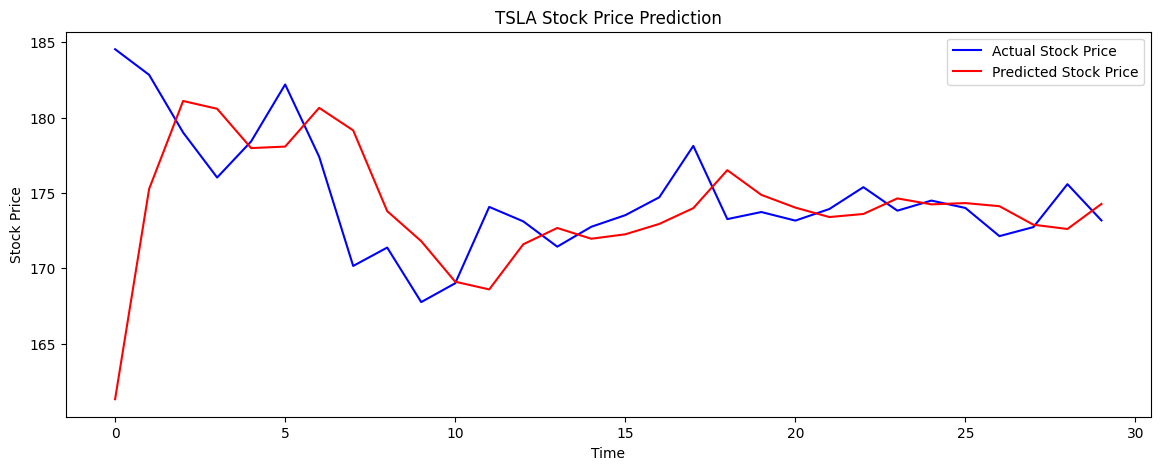

In [32]:
# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(y_test_scaled, color='blue', label='Actual Stock Price')
plt.plot(predictions, color='red', label='Predicted Stock Price')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()